# Dueling Q Learning

In [ ]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
import matplotlib.pyplot as plt
import pyvirtualdisplay
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import Dataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def preprocess(state):
    return state

class ReplayBuffer:
    def __init__(self, env, maxlen=10000):
        self.env = env
        self.buffer = deque(maxlen=maxlen)
        self.maxlen = maxlen
        self.fill()

    def __len__(self):
        return len(self.buffer)

    def fill(self):
        while len(self.buffer) < self.maxlen:
            state = self.env.reset()
            done = False
            while not done:
                action = self.env.action_space.sample()
                next_state, reward, done, _ = self.env.step(action)
                self.buffer.append((preprocess(state), action, reward, preprocess(next_state), done))
                state = next_state

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, n_samples):
        return zip(*random.sample(self.buffer, n_samples))

In [ ]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, device="cpu"):
        super(Policy, self).__init__()
        self.value = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1))
        self.advantage = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim))
        self.device = device
        self.action_space = torch.arange(action_dim)

    def forward(self, state):
        state = torch.tensor(state).float()
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        value = self.value(state)
        advantage = self.advantage(state)
        return value + (advantage - advantage.mean(1, keepdim=True))

    def q(self, state, action):
        action = torch.tensor(action)
        q_values = self.forward(state)
        return q_values[range(q_values.size(0)), action]

    def select_action(self, state, epsilon=0.0):
        if torch.rand(1) < epsilon:
            return self.action_space[torch.randint(0, self.action_space.size(0), (1,)).item()]
        else:
            with torch.no_grad():
                return self.forward(state).argmax(1)

In [ ]:
class QLearning:
    def __init__(self, env, policy, lr=1e-3, device="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.buffer = ReplayBuffer(env, maxlen=10000)
        self.device = device
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

    def train_epoch(self, batch_size=32, max_steps=10000, gamma=1, epsilon=0.1):
        self.policy.train()
        state = self.env.reset()
        done = False
        step = 0
        train_loss = 0.0
        episode_reward = 0.0

        while not done and step < max_steps:
            self.optimizer.zero_grad()

            # Generate samples and add to buffer
            with torch.no_grad():
                action = self.policy.select_action(preprocess(state), epsilon=epsilon)
            next_state, reward, done, _ = self.env.step(action)
            episode_reward += reward
            self.buffer.add(preprocess(state), action, reward, preprocess(next_state), done)

            # Sample batch_size elements from buffer and compute q_value
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.buffer.sample(batch_size)
            reward_batch = torch.tensor(reward_batch).float().to(self.device)
            done_batch = torch.tensor(done_batch).int().to(self.device)

            with torch.no_grad():
                target = reward_batch + gamma * (1 - done_batch) * torch.max(self.policy(next_state_batch), dim=1).values
            loss = nn.MSELoss()(target, self.policy.q(state_batch, action_batch))
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()

            # Closing up
            state = next_state
            step += 1

        return train_loss, episode_reward

    def train(self, n_episodes, evaluate_n_episodes=10, print_every=5, epsilon=0.1, gamma=1):
        history = {"train_loss": [], "reward": []}
        for episode in range(n_episodes):
            loss, reward = self.train_epoch(gamma=gamma, epsilon=epsilon * (1 - episode / n_episodes))
            history["train_loss"].append(loss)
            history["reward"].append(reward)
            if (episode + 1) % print_every == 0:
                print(f"Episode {episode + 1}: average reward over {evaluate_n_episodes} episodes: {reward}")
        return history

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
policy = Policy(env.observation_space.shape[0], env.action_space.n)
ql = QLearning(env, policy, lr=5e-4)
history = ql.train(n_episodes=1000, evaluate_n_episodes=1, epsilon=0.3, print_every=50)

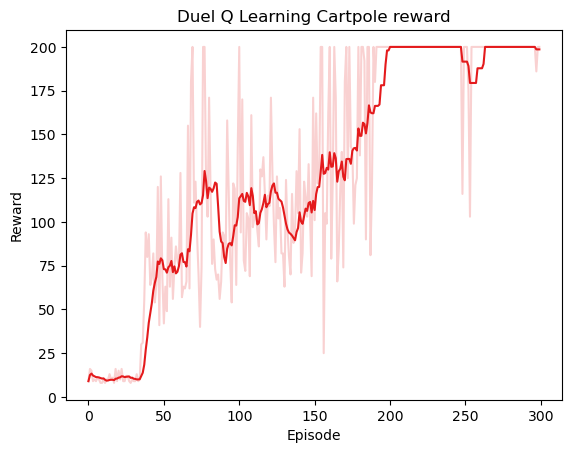

In [2]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/ValueBasedMethods/DuelQ/reward.npy")]

colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward[:300], c=colors[i], alpha=0.2)
    plt.plot(smooth(reward[:300], 10), c=colors[i])
plt.title("Duel Q Learning Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()